This analysis explores hospital admission patterns, billing behavior, and clinical indicators to identify trends, key drivers, and forecast future admission demand for operational planning.


In [45]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("C:/Users/LIDAC/OneDrive/Desktop/healthcare_analytics/data/healthcare_dataset.csv")

df.head()

,name,age,gender,blood type,medical condition,date of admission,doctor,hospital,insurance Provider,billing amount,room number,admission type,discharge date,medication,test results
0,Bobby JacksOn,30,Male,B-,Cancer,31/01/2024,Matthew Smith,Sons and Miller,Blue Cross,18856.28131,328,Urgent,02/02/2024,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,20/08/2019,Samantha Davies,Kim Inc,Medicare,33643.32729,265,Emergency,26/08/2019,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,22/09/2022,Tiffany Mitchell,Cook PLC,Aetna,27955.09608,205,Emergency,07/10/2022,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,18/11/2020,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.78241,450,Elective,18/12/2020,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,19/09/2022,Kathleen Hanna,White-White,Aetna,14238.31781,458,Urgent,09/10/2022,Penicillin,Abnormal


In [46]:
df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')


In [47]:
# Ensure column names are clean
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
)

# Convert dates again (safe to do)
df["date_of_admission"] = pd.to_datetime(
    df["date_of_admission"], format="%d/%m/%Y", errors="coerce"
)
df["discharge_date"] = pd.to_datetime(
    df["discharge_date"], format="%d/%m/%Y", errors="coerce"
)

# Create length of stay
df["length_of_stay"] = (
    df["discharge_date"] - df["date_of_admission"]
).dt.days

df["length_of_stay"].head()


0     2
1     6
2    15
3    30
4    20
Name: length_of_stay, dtype: int64

In [48]:
df.shape
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   name                55500 non-null  object        
 1   age                 55500 non-null  int64         
 2   gender              55500 non-null  object        
 3   blood_type          55500 non-null  object        
 4   medical_condition   55500 non-null  object        
 5   date_of_admission   55500 non-null  datetime64[ns]
 6   doctor              55500 non-null  object        
 7   hospital            55500 non-null  object        
 8   insurance_provider  55500 non-null  object        
 9   billing_amount      55500 non-null  float64       
 10  room_number         55500 non-null  int64         
 11  admission_type      55500 non-null  object        
 12  discharge_date      55500 non-null  datetime64[ns]
 13  medication          55500 non-null  object    

,age,billing_amount,room_number,length_of_stay
count,55500.000000,55500.000000,55500.000000,55500.000000
mean,51.539459,25539.316097,301.134829,15.509009
std,19.602454,14211.454431,115.243069,8.659600
min,13.000000,-2008.492140,101.000000,1.000000
25%,35.000000,13241.224655,202.000000,8.000000
50%,52.000000,25538.069380,302.000000,15.000000
75%,68.000000,37820.508432,401.000000,23.000000
max,89.000000,52764.276740,500.000000,30.000000


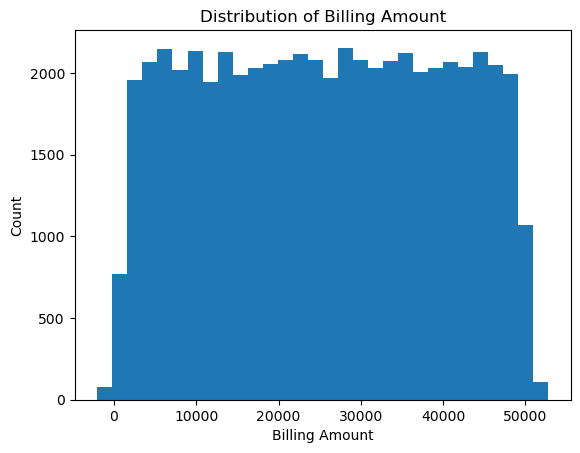

In [50]:
#Distribution of billing amount
plt.figure()
df["billing_amount"].plot(kind="hist", bins=30)
plt.title("Distribution of Billing Amount")
plt.xlabel("Billing Amount")
plt.ylabel("Count")
plt.show()

Billing amounts are right-skewed, indicating a small number of high-cost cases.

<Figure size 640x480 with 0 Axes>

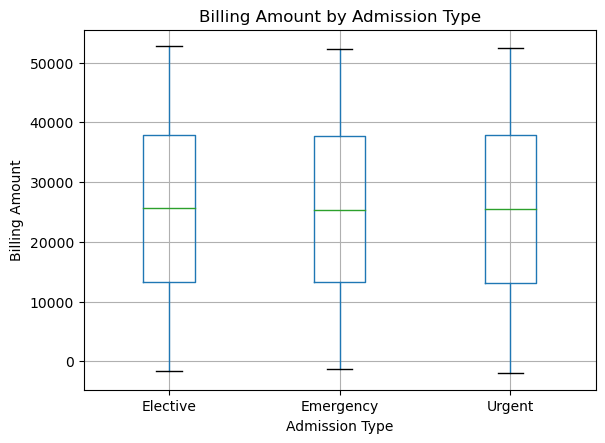

In [51]:
#Billing by admission type
plt.figure()
df.boxplot(column="billing_amount", by="admission_type")
plt.title("Billing Amount by Admission Type")
plt.suptitle("")
plt.xlabel("Admission Type")
plt.ylabel("Billing Amount")
plt.show()


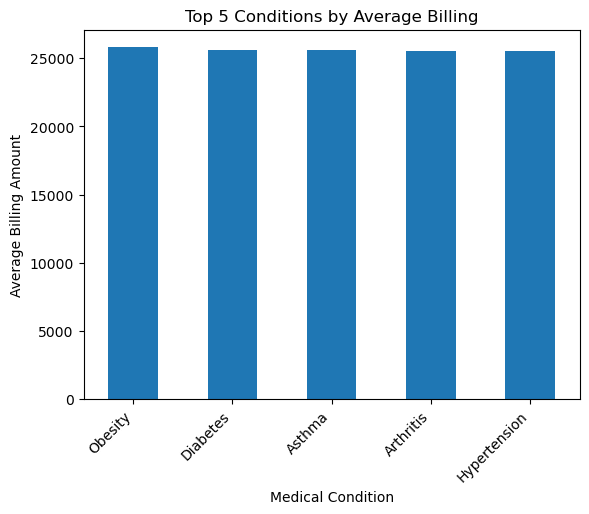

In [52]:
#Top 5 average billing by medical condition
avg_bill_condition = (
    df.groupby("medical_condition")["billing_amount"]
      .mean()
      .sort_values(ascending=False)
      .head(5)
)

plt.figure()
avg_bill_condition.plot(kind="bar")
plt.title("Top 5 Conditions by Average Billing")
plt.xlabel("Medical Condition")
plt.ylabel("Average Billing Amount")
plt.xticks(rotation=45, ha="right")
plt.show()


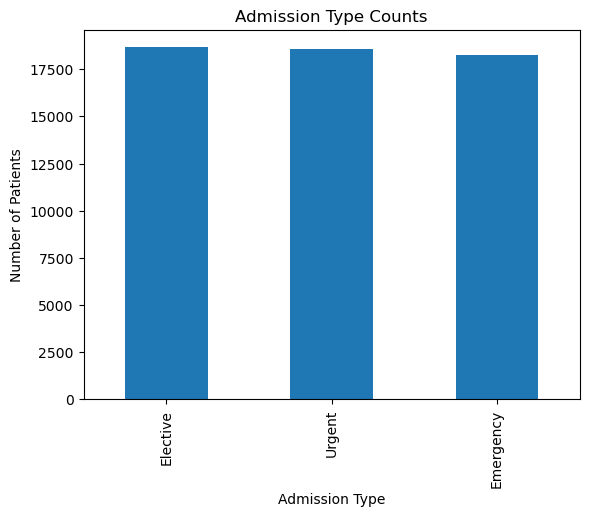

In [53]:
#Admission type freq
plt.figure()
df["admission_type"].value_counts().plot(kind="bar")
plt.title("Admission Type Counts")
plt.xlabel("Admission Type")
plt.ylabel("Number of Patients")
plt.show()


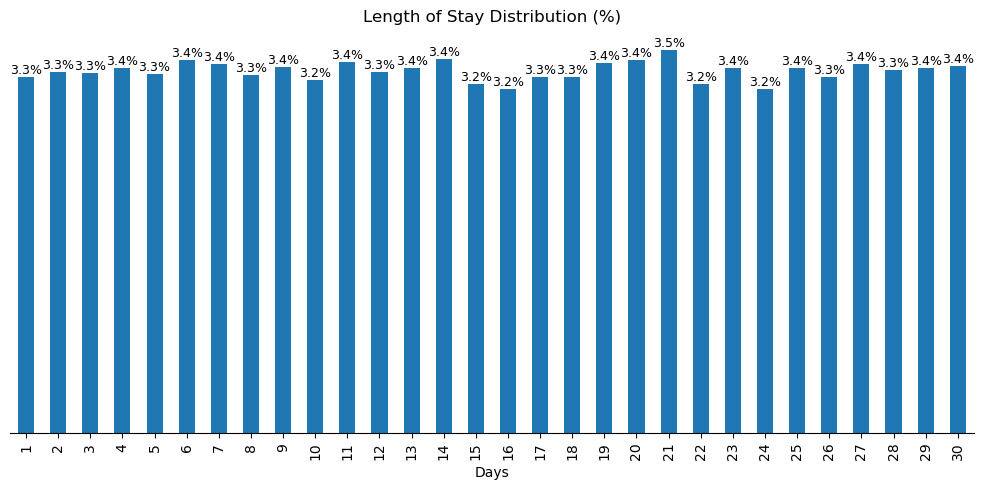

In [78]:
import matplotlib.pyplot as plt

# Count stays per day
los_counts = df['length_of_stay'].value_counts().sort_index()

# Convert to percentages
los_pct = los_counts / los_counts.sum() * 100

ax = los_pct.plot(kind='bar', figsize=(10,5))

# Add percentage labels
for i, v in enumerate(los_pct):
    ax.text(i, v, f"{v:.1f}%", ha='center', va='bottom', fontsize=9)

ax.set_title("Length of Stay Distribution (%)")
ax.set_xlabel("Days")
ax.set_ylabel("Percentage of Patients (%)")

ax.yaxis.set_visible(False)
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()



No single length of stay dominates the distribution; patient stays are spread relatively evenly across durations, with each day accounting for a small percentage of total admissions.

In [55]:
# Create abnormal flag from test_results
df["is_abnormal"] = df["test_results"].str.lower().eq("abnormal")

df["is_abnormal"].value_counts()



False    36873
True     18627
Name: is_abnormal, dtype: int64

In [56]:
abnormal_rate = df["is_abnormal"].mean() * 100
abnormal_rate


33.56216216216216

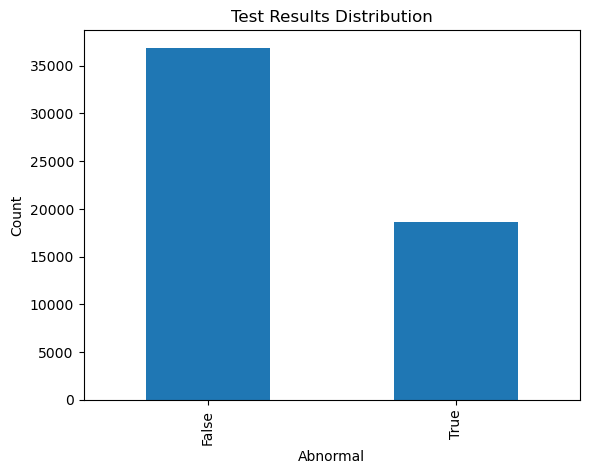

In [57]:
plt.figure()
df["is_abnormal"].value_counts().plot(kind="bar")
plt.title("Test Results Distribution")
plt.xlabel("Abnormal")
plt.ylabel("Count")
plt.show()


The distribution of test results is imbalanced, with normal outcomes predominating; however, abnormal cases remain significant and warrant focused analysis.

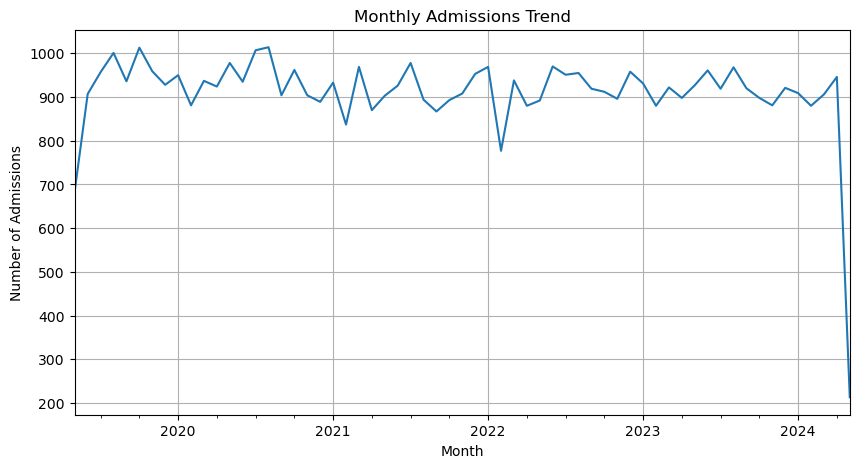

In [58]:
df['date_of_admission'] = pd.to_datetime(df['date_of_admission'])
df['admission_month'] = df['date_of_admission'].dt.to_period('M')
import matplotlib.pyplot as plt

monthly_admissions = df.groupby('admission_month').size()

plt.figure(figsize=(10,5))
monthly_admissions.plot()
plt.title("Monthly Admissions Trend")
plt.xlabel("Month")
plt.ylabel("Number of Admissions")
plt.grid(True)
plt.show()



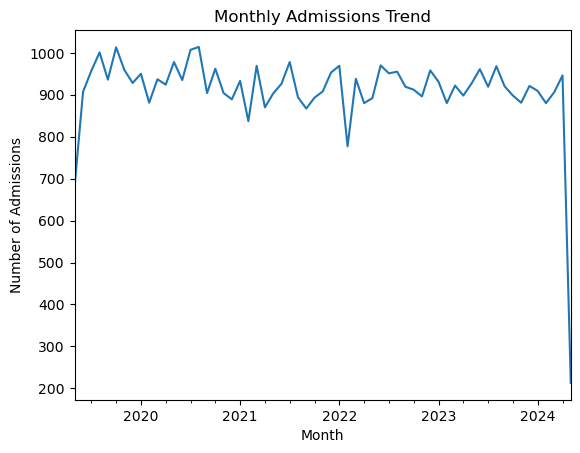

In [59]:
monthly_admissions = df.groupby("admission_month").size()

plt.figure()
monthly_admissions.plot()
plt.title("Monthly Admissions Trend")
plt.xlabel("Month")
plt.ylabel("Number of Admissions")
plt.show()


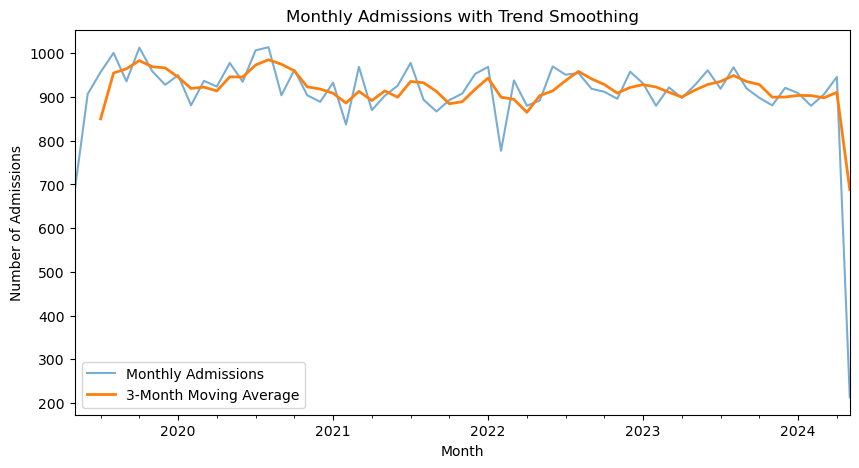

In [34]:
monthly_admissions_ma = monthly_admissions.rolling(3).mean()

plt.figure(figsize=(10,5))
monthly_admissions.plot(label='Monthly Admissions', alpha=0.6)
monthly_admissions_ma.plot(label='3-Month Moving Average', linewidth=2)
plt.legend()
plt.title("Monthly Admissions with Trend Smoothing")
plt.xlabel("Month")
plt.ylabel("Number of Admissions")
plt.show()


Trend smoothing reveals a largely stable pattern in monthly admissions with minor short-term fluctuations and no evidence of sustained growth or decline over the study period.

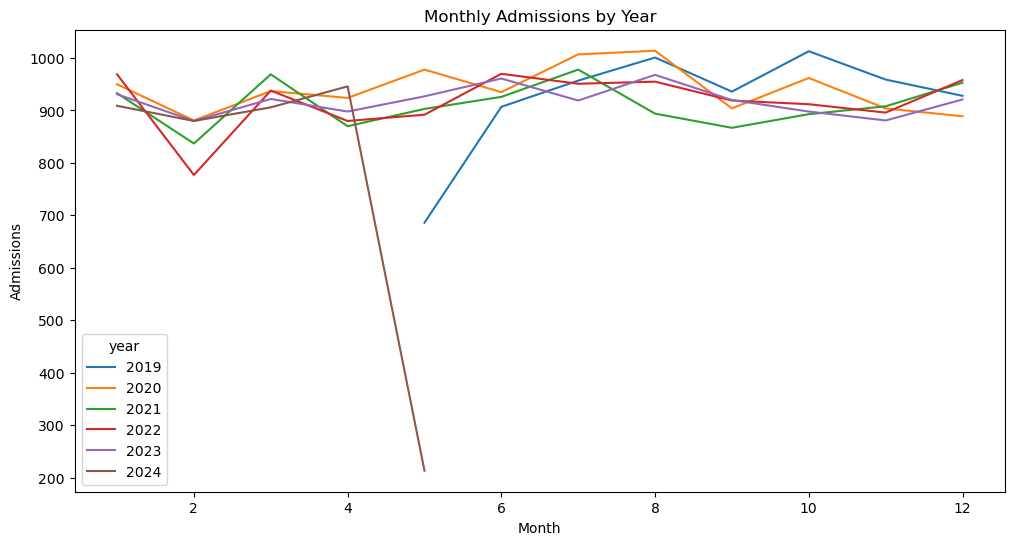

In [60]:
df['year'] = df['date_of_admission'].dt.year
df['month'] = df['date_of_admission'].dt.month

year_month = df.groupby(['year', 'month']).size().unstack()

year_month.T.plot(figsize=(12,6))
plt.title("Monthly Admissions by Year")
plt.xlabel("Month")
plt.ylabel("Admissions")
plt.show()


Most years show their highest admissions between July and August, suggesting increased demand during this period.
Aside from one anomaly, the monthly trends closely track each other, indicating stable year-over-year seasonality.

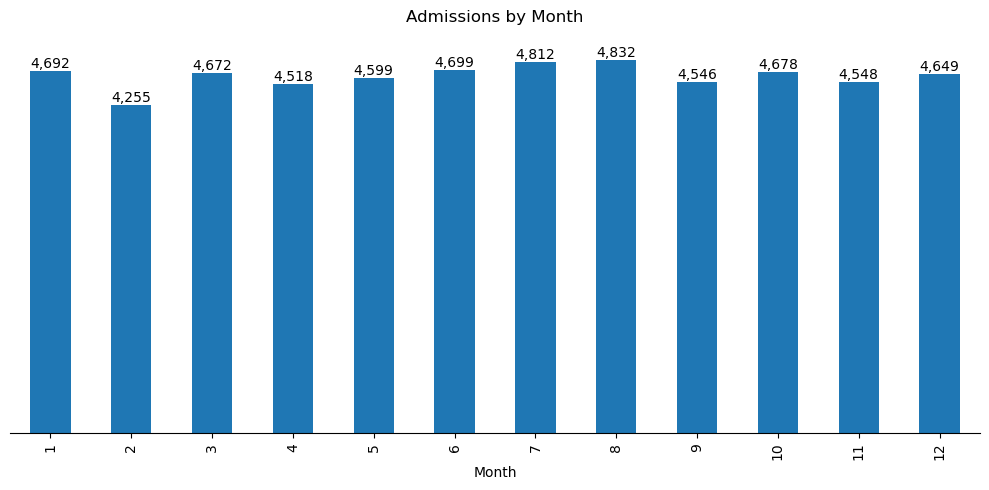

In [72]:
import matplotlib.pyplot as plt

seasonality = df.groupby(df['date_of_admission'].dt.month).size()

ax = seasonality.plot(kind='bar', figsize=(10,5))
ax.yaxis.set_visible(False)
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
for i, v in enumerate(seasonality):
    ax.text(i, v, f"{v:,}", ha='center', va='bottom', fontsize=10)

ax.set_title("Admissions by Month")
ax.set_xlabel("Month")

ax.set_ylim(0, max(seasonality) * 1.08)

plt.tight_layout()
plt.show()



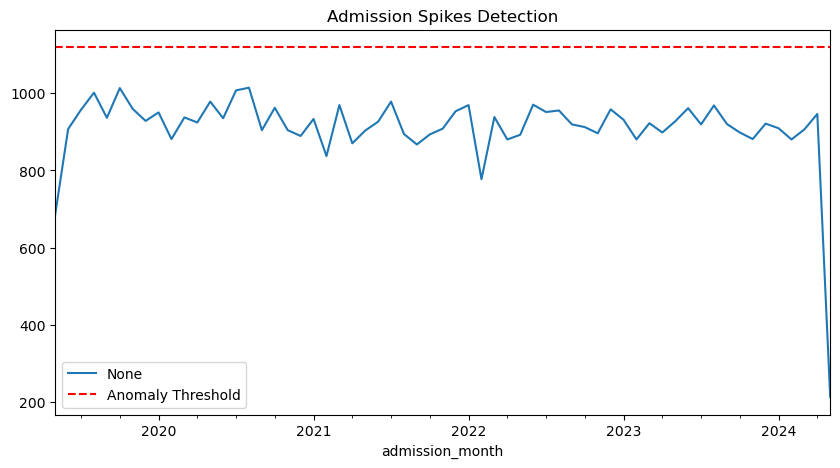

In [62]:
threshold = monthly_admissions.mean() + 2 * monthly_admissions.std()

plt.figure(figsize=(10,5))
monthly_admissions.plot()
plt.axhline(threshold, color='red', linestyle='--', label='Anomaly Threshold')
plt.legend()
plt.title("Admission Spikes Detection")
plt.show()


Monthly admissions show limited volatility and remain consistently below the anomaly threshold, indicating no evidence of abnormal spikes over the observed period

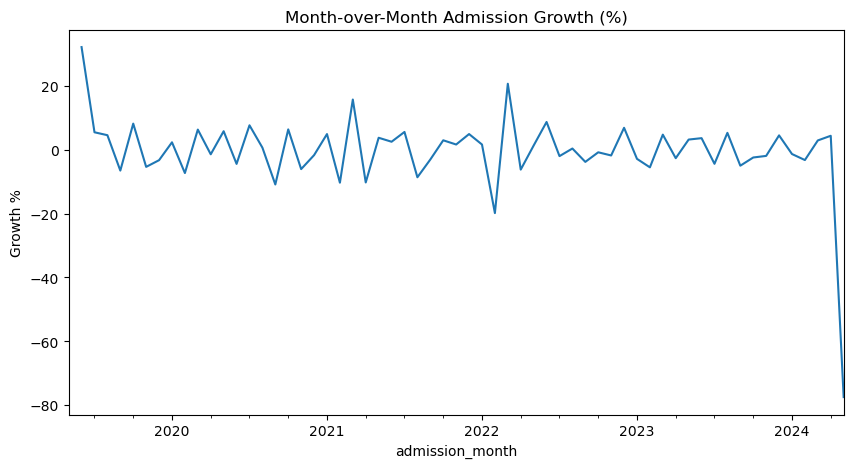

In [63]:
growth = monthly_admissions.pct_change() * 100

growth.plot(figsize=(10,5))
plt.title("Month-over-Month Admission Growth (%)")
plt.ylabel("Growth %")
plt.show()


In [64]:
print("Peak month:", monthly_admissions.idxmax())
print("Lowest month:", monthly_admissions.idxmin())
print("Overall trend:", "Increasing" if monthly_admissions.iloc[-1] > monthly_admissions.iloc[0] else "Decreasing")


Peak month: 2020-08
Lowest month: 2024-05
Overall trend: Decreasing


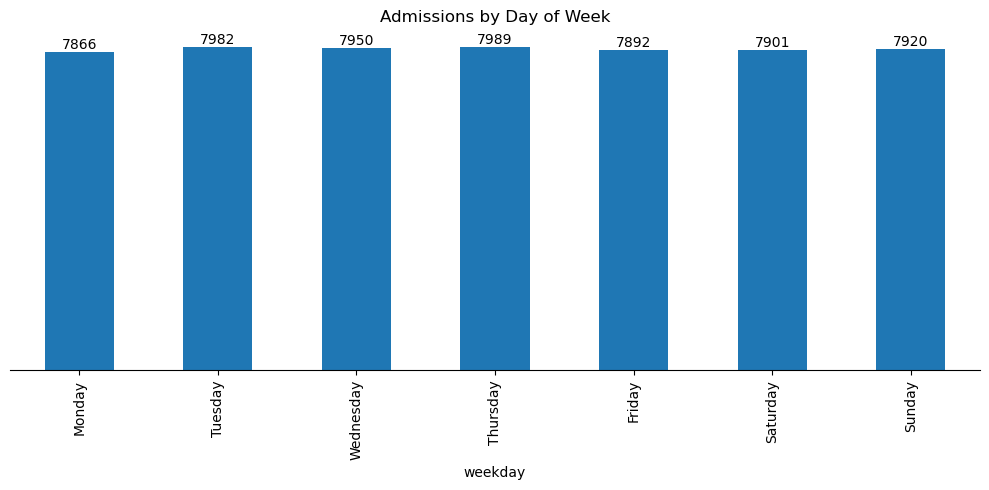

In [71]:
import matplotlib.pyplot as plt

counts = df.groupby('weekday').size().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)

ax = counts.plot(kind='bar', figsize=(10,5))

ax.yaxis.set_visible(False)

for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

for i, v in enumerate(counts):
    ax.text(i, v, f"{v}", ha='center', va='bottom', fontsize=10)

ax.set_title("Admissions by Day of Week")
plt.tight_layout()
plt.show()


Admissions remain consistent throughout the week with only marginal variation, indicating that weekday effects do not significantly influence admission volume.


In [66]:
before = df[df['date_of_admission'] < '2022-01-01'].shape[0]
after = df[df['date_of_admission'] >= '2022-01-01'].shape[0]

print("Before:", before)
print("After:", after)


Before: 29603
After: 25897


Forecasting Approach:
Exponential Smoothing was chosen due to its suitability for short-term trend forecasting without requiring extensive historical data.

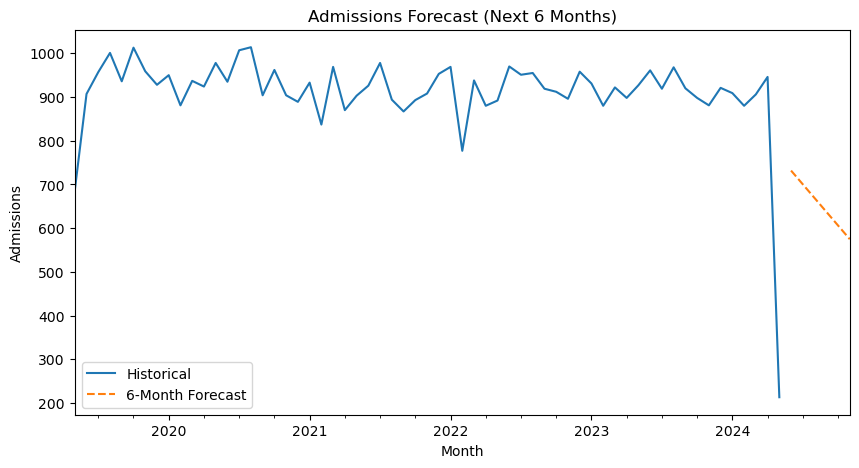

In [67]:
monthly_admissions = monthly_admissions.sort_index()
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(
    monthly_admissions,
    trend='add',
    seasonal=None
).fit()

forecast_6m = model.forecast(6)
plt.figure(figsize=(10,5))
monthly_admissions.plot(label='Historical')
forecast_6m.plot(label='6-Month Forecast', linestyle='--')
plt.legend()
plt.title("Admissions Forecast (Next 6 Months)")
plt.xlabel("Month")
plt.ylabel("Admissions")
plt.show()
#“The forecast projects a continued upward trend over the next six months, suggesting the need for proactive capacity and staffing planning

In [68]:
forecast = model.forecast(6)
print("Expected peak capacity needed:", forecast.max())


Expected peak capacity needed: 731.6714208515574


In [69]:
summary = pd.DataFrame({
    "Metric": [
        "Total Admissions",
        "Average Monthly Admissions",
        "Peak Month",
        "Lowest Month"
    ],
    "Value": [
        len(df),
        round(monthly_admissions.mean(), 2),
        monthly_admissions.idxmax(),
        monthly_admissions.idxmin()
    ]
})

summary


,Metric,Value
0,Total Admissions,55500
1,Average Monthly Admissions,909.84
2,Peak Month,2020-08
3,Lowest Month,2024-05


Key Recommendations:
Increase weekday staffing, especially Mondays
Allocate resources to high-volume departments
Use rolling forecasts for short-term capacity planning
Monitor deviations from forecast as early warning signals

Assumption
External factors like policy changes, pandemics are not explicitly modeled
Forecast is intended for short-term planning only
Data quality depends on source accuracy

Conclusion
The analysis identified operational and seasonal drivers of hospital admissions, with weekday concentration and departmental imbalance. Forecasts suggest sustained demand growth, reinforcing the need for proactive resource planning.